# Problem 1
(Wasserman, 2003) A random variable Z has an *inverse Gaussian distribution*
if it has density
$$f(z|\theta_1, \theta2)=z^{-3/2} e^{-\theta_1 z -\theta_2/z + 2 \sqrt{\theta_1 \theta_2}
+\log{\sqrt{2\theta_2}}}$$
for $z>0$, where $\theta_1>0$ and $\theta_2>0$ are parameters. It can be shown that
$E(Z)=\sqrt{\theta_2/\theta_1}$ and $E(1/Z)=\sqrt{\theta_1/\theta_2}+1/(2\theta_2)$.

## (a) 
**Let $θ_1 = 1.5$ and $θ_2 = 2$. Draw a sample of size 1,000**
**using the independence-Metropolis-Hastings method**
**with a Gamma distribution as the proposal density.**
**To assess the accuracy of the method,**
**compare the mean of Z and 1/Z from the sample to the theoretical means.**
**Try different Gamma distributions to see if you can get an accurate sample.**

Let's get samples using the MCMC-MH algorithm.
I think 1000 samples are too small to approximate the true mean. So I will draw more samples.
Note that

$$ log{f(z|\theta_1, \theta_2)} \propto -\frac{3}{2} log(z) - \theta_1 z - \frac{\theta_2}{z} + 2 \sqrt{\theta_1 \theta_2} + log{\sqrt{2 \theta_2}} $$

and gamma density's log kernel is proportional to $(\alpha -1) log{x} - \beta x$.

I put gamma( $\alpha=3, \beta=4$ ) (here, $\beta$ is rate parameter) for the proposal density. 
I tried many parameter combinations, and checked they worked well generally (without too unreasonable parameters).
To do this work, only needed thing is to change the argument value 'shape','rate' in the line:

    gamma_sampler_s3_r4 = partial(gamma_sampler, shape=3, rate=4)
    
It is quite easy :D, 
Moreover, I checked this algorithm converges well with other initial points.
However, I don't want to make this report too long. I will skip to report the other trials here.

In [8]:
from math import log, sqrt, exp
from random import gammavariate, normalvariate, seed
from functools import partial

from MCMC_MH_Core import MCMC_MH, MCMC_Diag

seed(20220305)

# For Z
def inv_gaussian_log_density_kernel(eval_pt, param_vec):
    theta1 = param_vec[0]
    theta2 = param_vec[1]
    eval_pt = eval_pt[0]
    log_kernel = -(3/2)*log(eval_pt) 
    log_kernel -= (theta1*eval_pt + theta2/eval_pt )
    log_kernel += (2*sqrt(theta1*theta2) + (1/2)*log(2*theta2))
    return log_kernel

def gamma_sampler(last, shape, rate):
    #last: not used in indep.MCMC
    sample = gammavariate(shape, 1/rate)
    return [sample]

def gamma_log_density_kernel(from_smpl, to_smpl, shape, rate):
    #from_smpl: not used in indep.MCMC
    to_smpl = to_smpl[0]
    log_kernel = (shape-1) * log(to_smpl) - rate*to_smpl
    return log_kernel

gamma_sampler_s3_r4 = partial(gamma_sampler, shape=3, rate=4)
gamma_log_density_kernel_s3_r4 = partial(gamma_log_density_kernel, shape=3, rate=4)
inv_gaussian_log_density_kernel_1p5_2 = partial(inv_gaussian_log_density_kernel, param_vec=(1.5, 2))

inst_p1a = MCMC_MH(inv_gaussian_log_density_kernel_1p5_2, gamma_log_density_kernel_s3_r4, gamma_sampler_s3_r4, [1], random_seed=20220224)
inst_p1a.generate_samples(50000, print_iter_cycle=10000)


iteration 0 / 50000
estimated running time:  0.0 min  0.4856586456298828 sec
iteration 10000 / 50000
iteration 20000 / 50000
iteration 30000 / 50000
iteration 40000 / 50000
iteration 50000 / 50000  done! (elapsed time for execution:  0.0 min  0.35318565368652344 sec)
acceptence rate:  0.5646


To check a convergence, let's draw a trace plot and an autocorrelation plot.

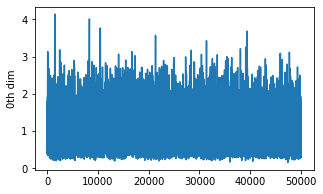

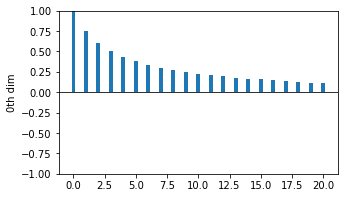

In [9]:
inst_p1a_diag = MCMC_Diag()
inst_p1a_diag.set_mc_sample_from_MCMC_MH(inst_p1a)
inst_p1a_diag.show_traceplot((1,1))
inst_p1a_diag.show_acf(20, (1,1))

When we observe the traceplot, I think it is enought to cut only a small number of samples for a burn-in part.
And, autocorrelation decreases moderately as lag increases.
So, I cut first 3000 samples as a burn-in period and pick one sample out of ten.
Our final sample size is $(50000-3000)/10=4700$.

Let's draw some plots after cutting.

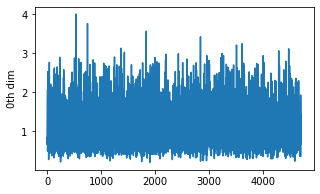

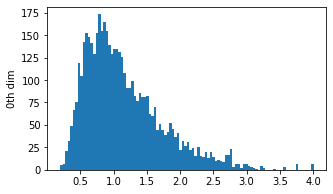

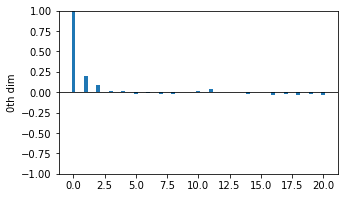

mean of z: [1.1551699454257693]
var of z: [0.3479724126655471]
0.95 cred.int. of z:  [[0.39225364064036106, 2.676383534429293]]
ESS: 1445.6262313659875


In [10]:
inst_p1a_diag.burnin(3000)
inst_p1a_diag.thinning(10)

inst_p1a_diag.show_traceplot((1,1))
inst_p1a_diag.show_hist((1,1))
inst_p1a_diag.show_acf(20, (1,1))
print("mean of z:", inst_p1a_diag.get_sample_mean()) #true: 1.1547
print("var of z:", inst_p1a_diag.get_sample_var())
print("0.95 cred.int. of z: ", inst_p1a_diag.get_sample_quantile([0.025, 0.975]))
print("ESS:", inst_p1a_diag.effective_sample_size(0))

Everything seems good. 
The sample mean is 1.155169, which is close to the true mean 1.1547.

To check one more time, let's invert the sample to $1/Z$.

In [11]:
#invert to 1/Z
inst_p1a_diag_inverted = MCMC_Diag()
inverted_MC_sample = [[1/sample[0]] for sample in inst_p1a.MC_sample]
inst_p1a_diag_inverted.set_mc_samples_from_list(inverted_MC_sample)
print("mean of 1/z: ", inst_p1a_diag_inverted.get_sample_mean()) #true: 1.1160
print("var of 1/z: ", inst_p1a_diag_inverted.get_sample_var())
print("0.95 cred.int. of 1/z: ", inst_p1a_diag_inverted.get_sample_quantile([0.025, 0.975]))

mean of 1/z:  [1.114934161461559]
var of 1/z:  [0.34321982037385124]
0.95 cred.int. of 1/z:  [[0.3728001017243211, 2.586129535217822]]


The mean value, 1.1149, is also very close to the true mean value, 1.1160. It looks fine.

## (b) 
**Draw a sample of size 1,000 using the random-walk Metropolis method.**
**Since $z > 0$ we cannot just use a Normal density.**
**Let $W = log(Z)$. Find the density of W.**
**Use the random-walk Metropolis method to get a sample $W_1,...,W_M$ and let $Z_i = e^{W_i}$.**
**Assess the accuracy of the simulation as in the previous part.**

Let's draw samples of W.
Note that,
$$f(w|\theta_1, \theta_2) \propto e^{-w/2 - \theta_1 e^w - \theta_2/{e^w} + 2\sqrt{\theta_1 \theta_2} + (1/2) log{2\theta_2} }$$
and
$$log{f(w|\theta_1, \theta_2)} \propto -\frac{w}{2} - \theta_1 e^{w} - \frac{\theta_2}{e^w} + 2 \sqrt{\theta_1 \theta_2} + \frac{1}{2} log{2 \theta_2} $$

iteration 0 / 50000
estimated running time:  0.0 min  0.4845857620239258 sec
iteration 10000 / 50000
iteration 20000 / 50000
iteration 30000 / 50000
iteration 40000 / 50000
iteration 50000 / 50000  done! (elapsed time for execution:  0.0 min  0.26558852195739746 sec)
acceptence rate:  0.5083


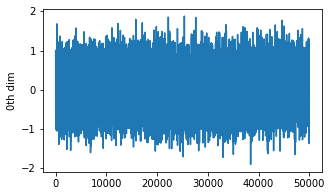

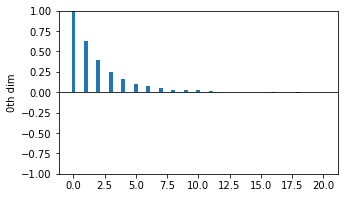

In [12]:
#for W
def log_inv_gaussian_log_density_kernel(eval_pt, param_vec):
    theta1 = param_vec[0]
    theta2 = param_vec[1]
    eval_pt = eval_pt[0]
    log_kernel = -0.5*eval_pt
    log_kernel -= (theta1*exp(eval_pt) + theta2/exp(eval_pt))
    log_kernel += (2*sqrt(theta1*theta2) + (1/2)*log(2*theta2))
    return log_kernel

def gaussian_sampler(last, sigma):
    #sigma: sd
    last = last[0]
    sample = normalvariate(last, sigma)
    return [sample]

def symmetric_log_density_kernel(from_smpl, to_smpl):
    return 0 #no need to implement

gaussian_sampler_sd1 = partial(gaussian_sampler, sigma=1)
log_inv_gaussian_log_density_kernel_1p5_2 = partial(log_inv_gaussian_log_density_kernel, param_vec=(1.5, 2))

inst_p1b = MCMC_MH(log_inv_gaussian_log_density_kernel_1p5_2, symmetric_log_density_kernel, gaussian_sampler_sd1, [1], random_seed=20220224+1)
inst_p1b.generate_samples(50000, print_iter_cycle=10000)
inst_p1b_diag = MCMC_Diag()
inst_p1b_diag.set_mc_sample_from_MCMC_MH(inst_p1b)
inst_p1b_diag.show_traceplot((1,1))
inst_p1b_diag.show_acf(20, (1,1))

Without cutting a burn-in period and thinning, it is nicer than the result of (a).
So here, I cut first 3000 samples and pick a sample out of four.
(This choice may hurt availability to compare the results between (a) and (b), hmm.)

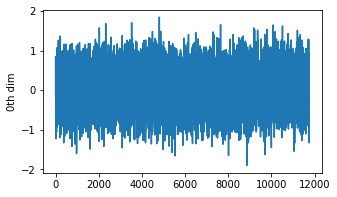

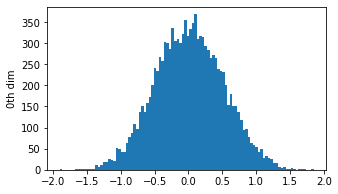

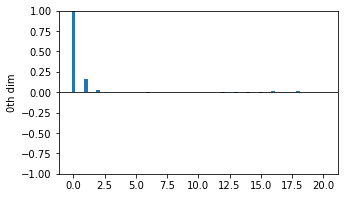

mean of w: [0.015674901337165054]
var of w: [0.2538020500999328]
0.95 cred.int. of w:  [[-0.9617071933419522, 1.0102707425767452]]
ESS: 3268.933019193798


In [13]:
inst_p1b_diag.burnin(3000)
inst_p1b_diag.thinning(4)

inst_p1b_diag.show_traceplot((1,1))
inst_p1b_diag.show_hist((1,1))
inst_p1b_diag.show_acf(20, (1,1))
print("mean of w:", inst_p1b_diag.get_sample_mean())
print("var of w:", inst_p1b_diag.get_sample_var())
print("0.95 cred.int. of w: ", inst_p1b_diag.get_sample_quantile([0.025, 0.975]))
print("ESS:", inst_p1b_diag.effective_sample_size(0))

Everything looks good. Let's invert to $Z=e^W$.

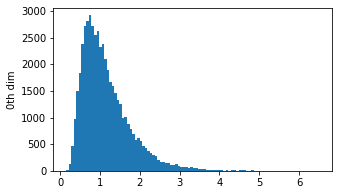

mean of z:  [1.1552993976143855]
var of z:  [0.3798889093975271]
0.95 cred.int. of z:  [[0.38023218941431347, 2.7335697851940854]]


In [14]:
#invert to Z
inst_p1b_diag_z = MCMC_Diag()
z_MC_sample = [[exp(sample[0])] for sample in inst_p1b.MC_sample]
inst_p1b_diag_z.set_mc_samples_from_list(z_MC_sample)
inst_p1b_diag_z.show_hist((1,1))
print("mean of z: ", inst_p1b_diag_z.get_sample_mean()) #true: 1.1547
print("var of z: ", inst_p1b_diag_z.get_sample_var())
print("0.95 cred.int. of z: ", inst_p1b_diag_z.get_sample_quantile([0.025, 0.975]))

The simulated mean is very close to the true mean, 1.1547.

Comparing this result with (a), we can say that we get a benefit from log-transform,
cause simulated samples of $W$ have less autocorrelation, so we get more samples (by less thinning) from the same number of MCMC iteration.